In [1]:
import json
import logging
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from train_models import create_avg_dataset
from collections import OrderedDict

%matplotlib inline

/home/ivan/Documentos/image-labeling-author-profiling/venv/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Lee todos los conjuntos de entrenamiento

In [2]:
BASE_PATH_DATA = '/media/ivan/DDE/datasets_proyecto_mt'

In [3]:
train_data_csv_paths = ['/datasets/en_train.csv', './datasets/es_train.csv', './datasets/ar_train.csv']
train_labels_json_paths = ['./authors_labels/en_train_labels.json', './authors_labels/es_train_labels.json','./authors_labels/ar_train_labels.json']
X_dataframes = [None for i in range(len(train_data_csv_paths))]
y_dataframes = [None for i in range(len(train_labels_json_paths))]
list_of_ids = [None for i in range(len(X_dataframes))]
i = 0
t_start = time()
for path_x, path_y in zip(train_data_csv_paths, train_labels_json_paths):
    list_of_ids[i] = path_x.strip().split('/')[2][:2]
    X = pd.read_csv(BASE_PATH_DATA + path_x, sep='\s*,\s*', header=0, encoding='ascii', engine='python')
    X, y_dataframes[i] = create_avg_dataset(X, path_y)
    y_pred_dict = OrderedDict([("class", y_dataframes[i])])
    X_dataframes[i] = pd.concat([X.reset_index(drop=True), pd.DataFrame.from_dict(y_pred_dict)], axis=1)
    i += 1
print("{} seconds to read csv's and create all dataframes".format(time() - t_start))

91.70015120506287 seconds to read csv's and create all dataframes


In [4]:
def save_plot_sum(categories, freqs, filename):
    plt.rcParams['figure.figsize'] = [15, 10]
    fig = plt.figure()
    plt.bar(categories, freqs)
    plt.xticks(np.arange(len(freqs)), categories, rotation=90, fontsize=15)
    lang, genre = filename.strip().split('_')
    languages_dict = {"EN" : "Inglés", "ES": "Español", "AR" : "Árabe"}
    genre_dict = {"f" : "Femenino" , "m" : "Masculino"}
    lang = languages_dict[lang]
    genre = genre_dict[genre]
    plt.title("Idioma: {}\nGénero: {}".format(lang, genre), fontsize=18)
    fig.savefig("./plots/" + filename + ".png", bbox_inches='tight')

In [5]:
def create_freqs_vectors(list_of_dataframes=X_dataframes, top_n=50, save_plots=False, order=True):
    authors_top_attr_sum = []
    authors_top_attr_names = []
    labels_languages = ["EN", "ES", "AR"]
    for i in range(len(X_dataframes)):
        grouped_sum_instances = X_dataframes[i].groupby('class').sum()
        females_freqs = grouped_sum_instances.loc["female", :]
        males_freqs = grouped_sum_instances.loc["male", :]
        if order == True:
            females_freqs = females_freqs.sort_values(ascending=False)
            males_freqs = males_freqs.sort_values(ascending=False)
        males_top_n_categories = males_freqs.keys()[:top_n]
        females_top_n_categories = females_freqs.keys()[:top_n]
        authors_top_attr_sum.append(males_freqs[:top_n])
        authors_top_attr_names.append(males_top_n_categories)
        authors_top_attr_sum.append(females_freqs[:top_n])
        authors_top_attr_names.append(females_top_n_categories)
        if save_plots:
            save_plot_sum(males_top_n_categories, males_freqs[:top_n], labels_languages[i] + "_m")
            save_plot_sum(females_top_n_categories, females_freqs[:top_n], labels_languages[i] + "_f")
    return authors_top_attr_sum, authors_top_attr_names

In [52]:
import itertools
from sklearn.preprocessing import Normalizer

authors_top_attr_sum, authors_top_attr_names = create_freqs_vectors(top_n=1000, save_plots=False, order=False)
languages = ["EN", "EN", "ES", "ES", "AR", "AR"]
sex = ["M", "F", "M", "F", "M", "F"]

file = open("diff_attr.txt", "w")
for pair in itertools.combinations([0, 1, 2, 3, 4, 5], 2):
    same_sex = True if pair[0] % 2 == pair[1] % 2 else False
    if same_sex:
        i = pair[0]
        j = pair[1]
    else:
        i = pair[0] if pair[0] % 2 else pair[1]
        j = pair[1] if pair[0] % 2 else pair[0]
    file.write("\n*{}-{}--{}-{}\n".format(languages[i], sex[i], languages[j], sex[j]))
    transformer_i = Normalizer().fit([authors_top_attr_sum[i]])
    transformer_j = Normalizer().fit([authors_top_attr_sum[j]])
    ti = transformer_i.transform([authors_top_attr_sum[i]])
    tj = transformer_j.transform([authors_top_attr_sum[j]])
    diff = ti - tj
#     print(np.max(diff))
#     print(np.min(diff))
    negative_attr = []
    positive_attr = []
    for category, value in zip(authors_top_attr_names[0], diff[0]):
        if value >= 0.015:
            positive_attr.append((category, value))
        if value <= -0.015:
            negative_attr.append((category, value))
    postive_concat = ["{} {}".format(t[0], t[1]) for t in positive_attr]
    postive_concat += ["{} {}".format(t[0], 0) for t in negative_attr]
    negative_concat = ["{} {}".format(t[0], 0) for t in positive_attr]
    negative_concat += ["{} {}".format(t[0], t[1]) for t in negative_attr]
    file.write("Atributos-{}  Atributos-{}\n".format(languages[i] + "-" + sex[i], languages[j] + "-" + sex[j]))
    for pos, neg in zip(postive_concat, negative_concat):
        file.write("{} {}\n".format(pos, neg))
#     print("\n".join(["{} {}".format(t[0], t[1]) for t in positive_attr]))
#     print("\n".join(["{} {}".format(t[0], t[1]) for t in negative_attr]))
file.close()

In [6]:
def print_pairs(attr_names, freqs, file):
    for attr, freq in zip(attr_names, freqs):
        file.write("{} {}\n".format(attr, freq))

In [8]:
from sklearn.preprocessing import Normalizer


top = 50
authors_top_attr_sum, authors_top_attr_names = create_freqs_vectors(top_n=1000, save_plots=False, order=False)
languages = ["EN", "EN", "ES", "ES", "AR", "AR"]
sex = ["M", "F", "M", "F", "M", "F"]

file = open("comparison_freqs_male.txt", "w")
# Hombres vs mujeres
user_en = authors_top_attr_sum[0]
user_es = authors_top_attr_sum[2]
user_ar = authors_top_attr_sum[4]
transformer_m_en = Normalizer().fit([user_en, user_es, user_ar])
norm_users = transformer_m_en.transform([user_en, user_es, user_ar])
# tj = transformer_j.transform([authors_top_attr_sum[j]])
# diff = ti - tj
user_en = norm_users[0]
user_es = norm_users[1]
user_ar = norm_users[2]
indexes_user_en = np.argsort(user_en)
attr_users_en = authors_top_attr_names[0][indexes_user_en]
indexes_user_es = np.argsort(user_es)
attr_users_es = authors_top_attr_names[1][indexes_user_es]
indexes_user_ar = np.argsort(user_ar)
attr_users_ar = authors_top_attr_names[2][indexes_user_ar]
top_100_en = attr_users_en[1000 - top:]
top_100_es = attr_users_es[1000 - top:]
top_100_ar = attr_users_ar[1000 - top:]
intersection_all_users = set(top_100_en).intersection(set(top_100_es).intersection(set(top_100_ar)))
indexes_users = np.array([])
for attr in intersection_all_users:
    idx = np.where(authors_top_attr_names[0] == attr)
    indexes_users = np.append(indexes_users, idx)
print(intersection_all_users)
indexes_users = indexes_users.astype(int)
file.write("EN\n")
print_pairs(intersection_all_users, user_en[indexes_users], file)
file.write("ES\n")
print_pairs(intersection_all_users, user_es[indexes_users], file)
file.write("AR\n")
print_pairs(intersection_all_users, user_ar[indexes_users], file)

file.close()
ar_complement = user_es + user_en
ar_complement = ar_complement / 2
diff_ar_complement = user_ar - ar_complement
for attr, freq in zip(authors_top_attr_names[0], diff_ar_complement):
    if freq <= - 0.005 or freq >= 0.01:
        print("{} {}".format(attr, freq))

{'menu', 'book_jacket', 'sweatshirt', 'packet', 'scoreboard', 'comic_book', 'envelope', 'stage', 'Windsor_tie', 'shoe_shop', 'military_uniform', 'suit', 'mortarboard', 'torch', 'fountain', 'groom', 'jersey', 'wig', 'academic_gown', 'brass', 'lab_coat', 'rugby_ball', 'monitor', 'screen', 'cash_machine', 'bow_tie', 'basketball', 'television', 'jigsaw_puzzle', 'web_site', 'ballplayer', 'abaya', 'soccer_ball'}
abaya 0.03995823035553881
academic_gown 0.015306607206195387
barbershop 0.01064260785142011
beer_glass -0.006190772278194868
binder 0.028046220569041304
bow_tie 0.023024847784833977
candle 0.010701141073873818
castle 0.015693517999832457
cinema -0.0054002638491537774
cloak 0.015424858407739717
electric_guitar -0.005401248764316087
envelope 0.07767484053309846
football_helmet 0.010724180414743049
fountain_pen 0.02400393153515324
gown 0.010128687655872354
home_theater -0.007158754206933467
lab_coat 0.032893258599105184
military_uniform 0.013529837125931143
mortarboard 0.011412948204598

In [24]:
female = {'jersey', 'sunglasses', 'academic_gown', 'theater_curtain', 'cloak', 'miniskirt', 'comic_book', 'Band_Aid', 'cash_machine', 'pajama', 'wig', 'stole', 'torch', 'monitor', 'fur_coat', 'packet', 'brassiere', 'suit', 'groom', 'book_jacket', 'gown', 'jigsaw_puzzle', 'screen', 'brass', 'sweatshirt', 'fountain', 'bow_tie', 'television', 'stage', 'lab_coat', 'mortarboard', 'hair_spray', 'abaya', 'web_site', 'menu', 'envelope'}
male = {'jersey', 'academic_gown', 'ballplayer', 'comic_book', 'cash_machine', 'rugby_ball', 'shoe_shop', 'wig', 'Windsor_tie', 'soccer_ball', 'torch', 'monitor', 'packet', 'suit', 'scoreboard', 'groom', 'book_jacket', 'jigsaw_puzzle', 'basketball', 'screen', 'brass', 'sweatshirt', 'fountain', 'bow_tie', 'television', 'stage', 'lab_coat', 'mortarboard', 'abaya', 'web_site', 'military_uniform', 'menu', 'envelope'}
print("Intersection")
print(female.intersection(male))
print("Difference F - M")
print(female.difference(male))
print("Difference M - F")
print(male.difference(female))

Intersection
{'jersey', 'academic_gown', 'comic_book', 'envelope', 'cash_machine', 'wig', 'torch', 'monitor', 'packet', 'suit', 'groom', 'book_jacket', 'jigsaw_puzzle', 'brass', 'fountain', 'sweatshirt', 'screen', 'bow_tie', 'television', 'stage', 'lab_coat', 'mortarboard', 'abaya', 'menu', 'web_site'}
Difference F - M
{'sunglasses', 'pajama', 'fur_coat', 'theater_curtain', 'cloak', 'miniskirt', 'brassiere', 'hair_spray', 'Band_Aid', 'stole', 'gown'}
Difference M - F
{'Windsor_tie', 'soccer_ball', 'ballplayer', 'rugby_ball', 'scoreboard', 'shoe_shop', 'military_uniform', 'basketball'}


In [ ]:
authors_top_attr_sum, authors_top_attr_names = create_freqs_vectors(top_n=1000, save_plots=False, order=False)
languages = ["EN", "EN", "ES", "ES", "AR", "AR"]
sex = ["M", "F", "M", "F", "M", "F"]

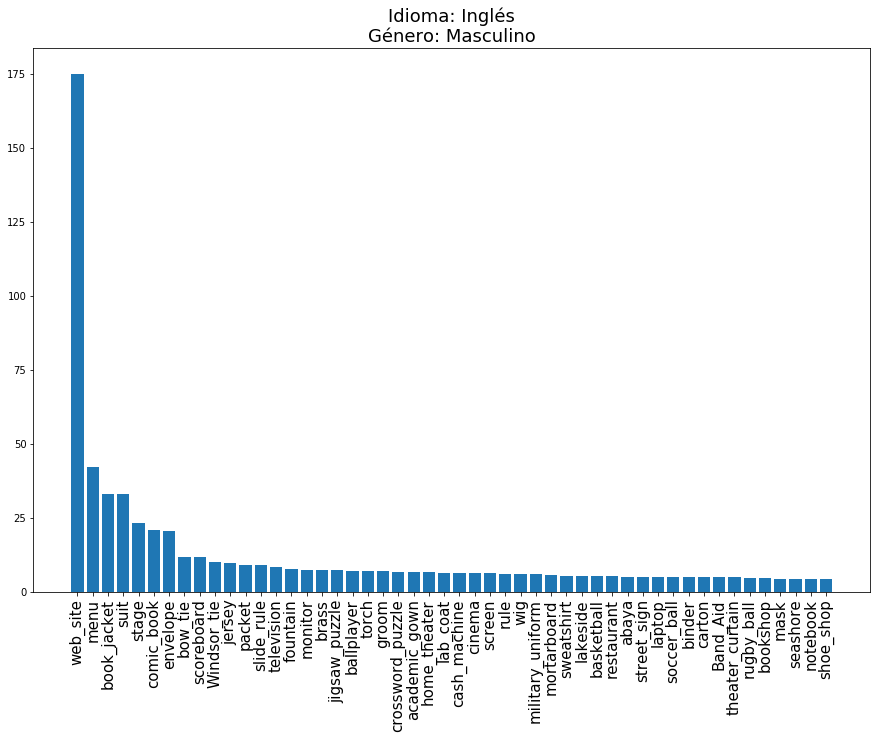

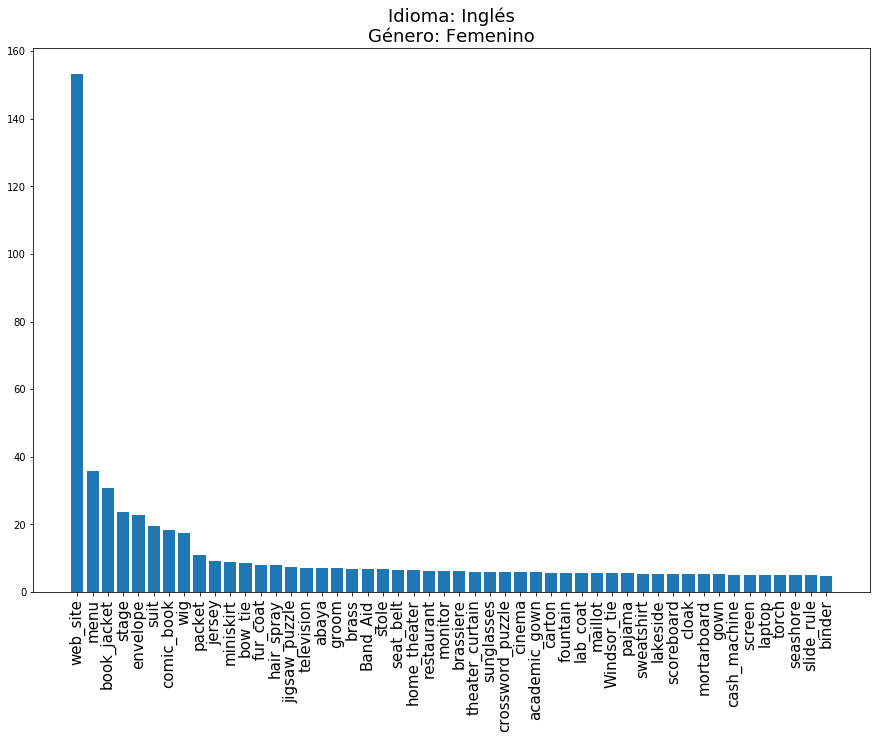

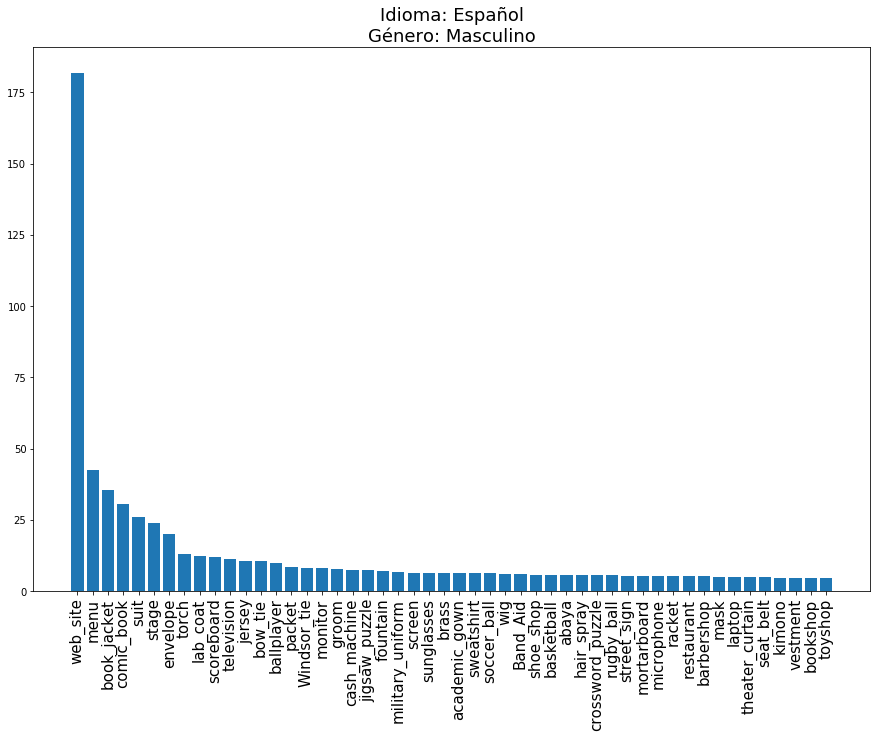

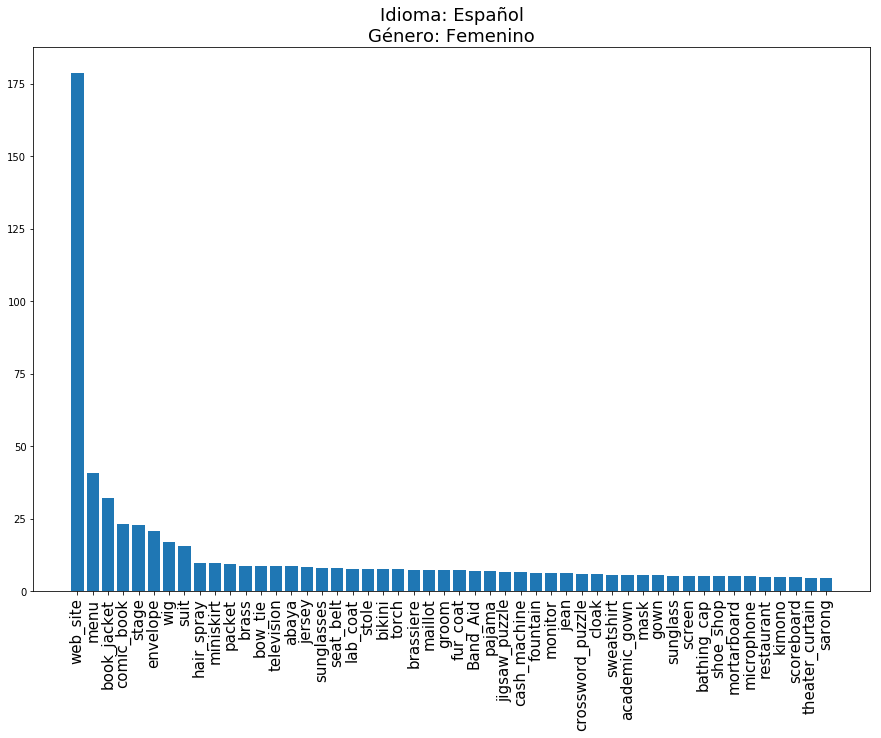

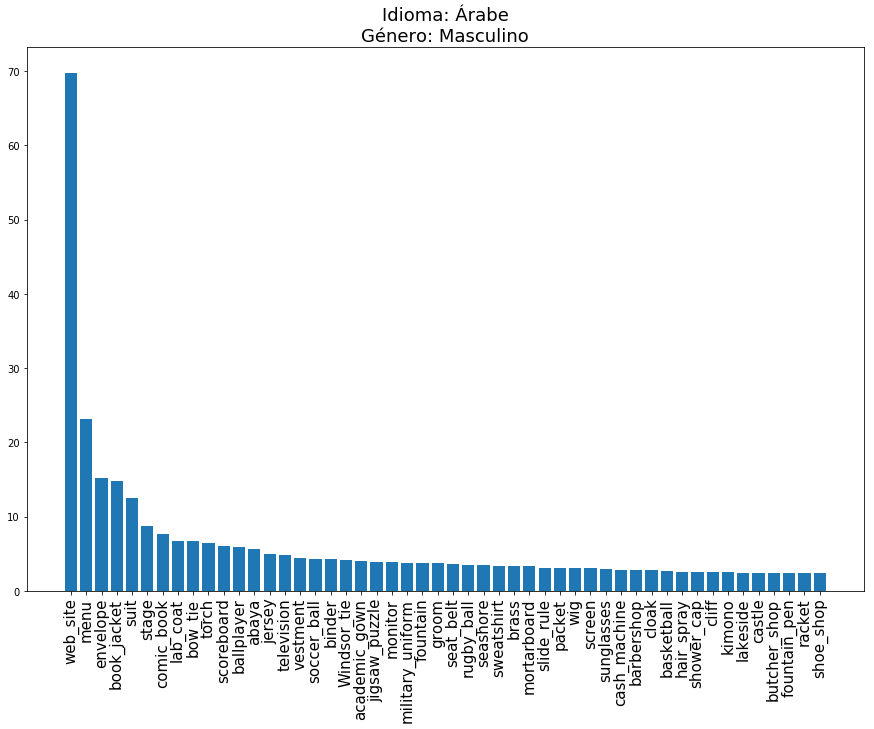

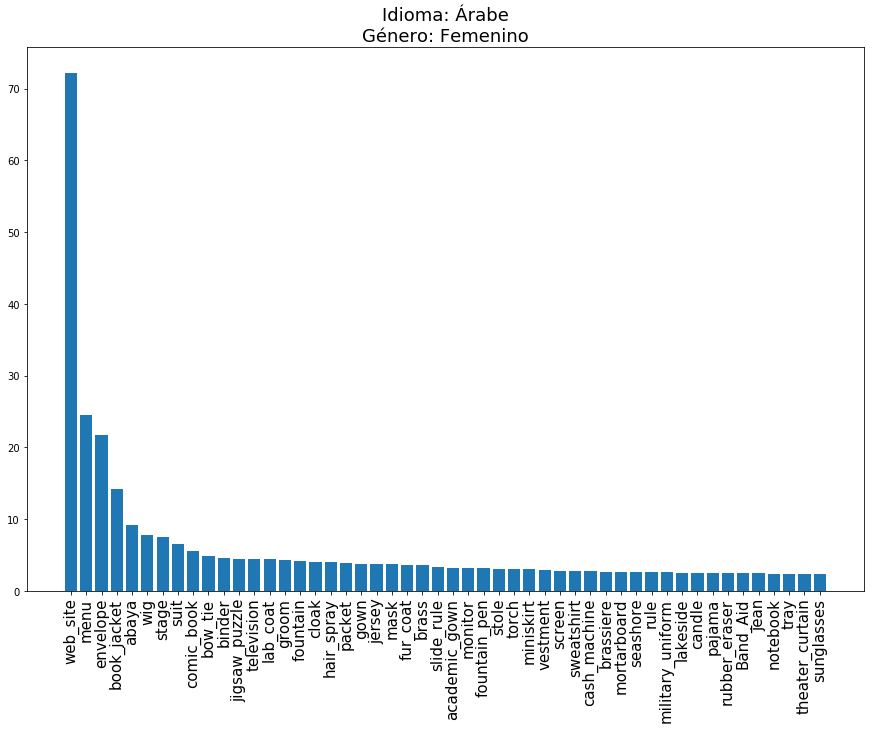

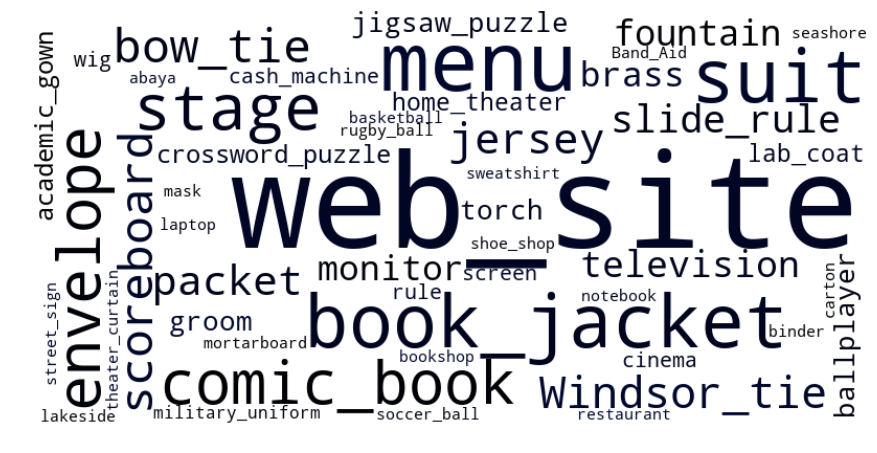

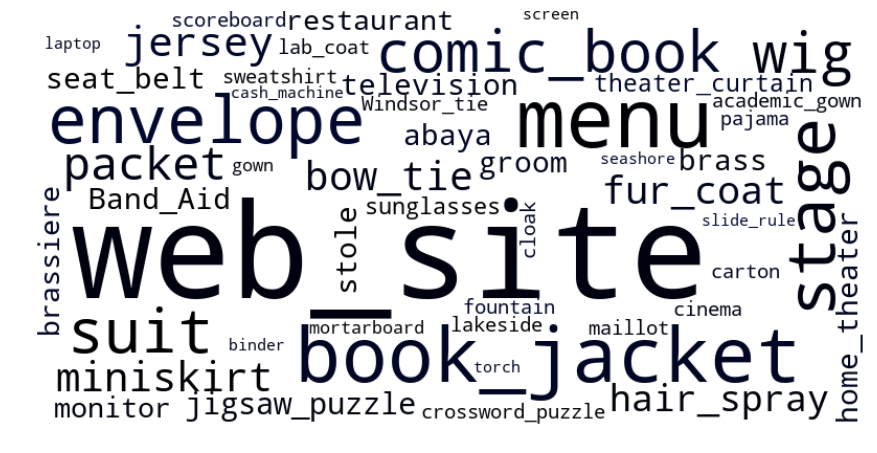

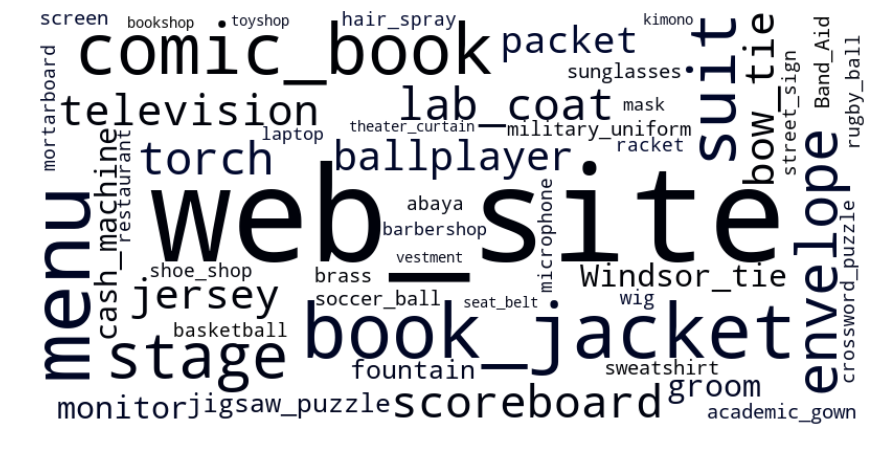

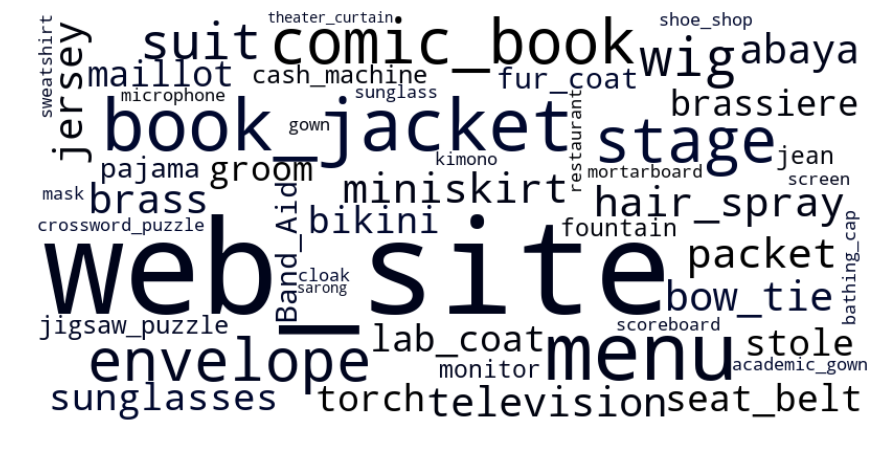

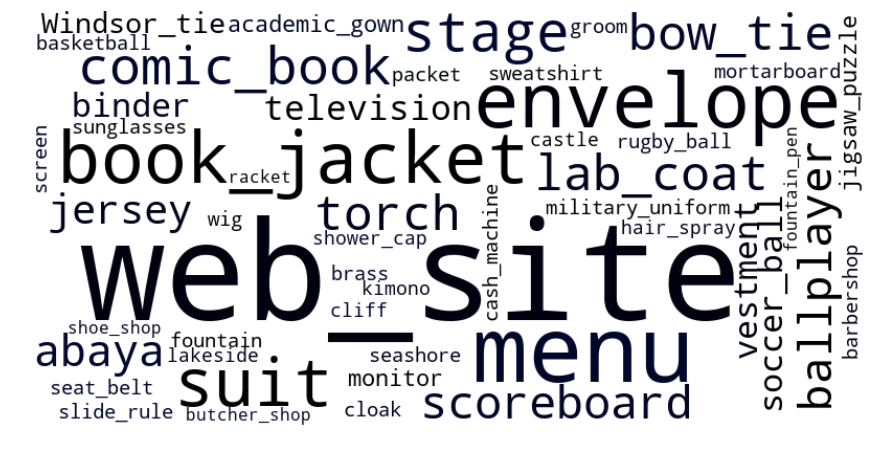

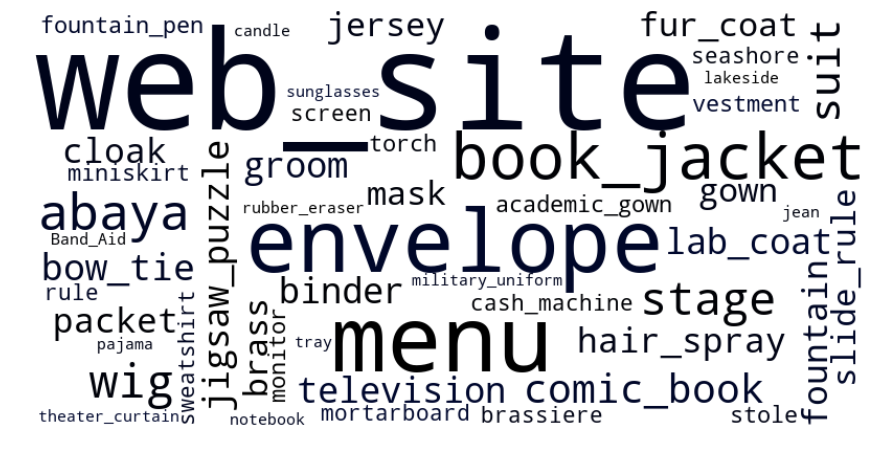

In [33]:
authors_top_attr_sum, authors_top_attr_names = create_freqs_vectors(top_n=50, save_plots=True)
plt.rcParams['figure.figsize'] = [15, 10]
languages = ["EN", "EN", "ES", "ES", "AR", "AR"]
sex = ["M", "F", "M", "F", "M", "F"]
wordcloud = WordCloud(width=800, height=400, max_words=50, background_color="white")
i = 0
for authors_sum in authors_top_attr_sum:
    wordcloud.generate_from_frequencies(frequencies=authors_sum)
    plt.figure()
    plt.imshow(wordcloud.recolor(color_func=grey_color_func), interpolation="bilinear")
    plt.axis("off")
    plt.show()
    wordcloud.to_file("./plots/{}_{}_wordcloud.png".format(languages[i], sex[i]))
    i += 1

In [7]:
labels_languages = ["EN", "EN", "ES", "ES", "AR", "AR"]
correlation_vars = []
vars_order = []
authors_top_attr_sum, authors_top_attr_names = create_freqs_vectors(top_n=50)
for i in range(len(authors_top_attr_sum) - 1):
    for j in range(i + 1, len(authors_top_attr_sum)):
        language_a = labels_languages[i]
        genre_a = "M" if i % 2 == 0 else "F"
        language_b = labels_languages[j]
        genre_b = "M" if j % 2 == 0 else "F"
        print("Comparando género {} en idioma {} con género {} en idioma {}".format(genre_a, language_a, genre_b, language_b))
        intersection = set(authors_top_attr_names[i]).intersection(set(authors_top_attr_names[j]))
        union = set(authors_top_attr_names[i]).union(set(authors_top_attr_names[j]))
        print("Intersección {}".format(len(intersection)))
        a = np.array(authors_top_attr_sum[i][list(intersection)])
        b = np.array(authors_top_attr_sum[j][list(intersection)])
        correlation_vars.append(a)
        correlation_vars.append(b)
        vars_order.append("{}_{}".format(genre_a, language_a))
        vars_order.append("{}_{}".format(genre_b, language_b))
#         print(authors_top_attr_sum[i][intersection_list])
#         print(authors_top_attr_sum[j][intersection_list])
#         print("Coeficiente de correlación =  {}".format(np.corrcoef(a, b)[0,1]))
        print("Coeficiente de Jaccard =  {}".format(len(intersection) / len(union)))
        print("Difference A - B")
        diff = set(authors_top_attr_names[i]).difference(set(authors_top_attr_names[j]))
        print(diff)
        print("Difference B - A")
        diff = set(authors_top_attr_names[j]).difference(set(authors_top_attr_names[i]))
        print(diff)

Comparando género M en idioma EN con género F en idioma EN
Intersección 39
Coeficiente de Jaccard =  0.639344262295082
Difference A - B
{'ballplayer', 'rugby_ball', 'rule', 'street_sign', 'military_uniform', 'notebook', 'bookshop', 'shoe_shop', 'soccer_ball', 'basketball', 'mask'}
Difference B - A
{'seat_belt', 'stole', 'gown', 'fur_coat', 'brassiere', 'sunglasses', 'cloak', 'hair_spray', 'maillot', 'miniskirt', 'pajama'}
Comparando género M en idioma EN con género M en idioma ES
Intersección 41
Coeficiente de Jaccard =  0.6949152542372882
Difference A - B
{'rule', 'notebook', 'seashore', 'cinema', 'slide_rule', 'home_theater', 'binder', 'carton', 'lakeside'}
Difference B - A
{'kimono', 'seat_belt', 'microphone', 'vestment', 'sunglasses', 'racket', 'barbershop', 'toyshop', 'hair_spray'}
Comparando género M en idioma EN con género F en idioma ES
Intersección 32
Coeficiente de Jaccard =  0.47058823529411764
Difference A - B
{'ballplayer', 'rugby_ball', 'rule', 'street_sign', 'military_un

## Cálculo de la ganancia de información

In [21]:
from sklearn.feature_selection import mutual_info_classif
labels = labels_languages = ["EN","ES", "AR"]
info_gain = [[] for i in range(len(X_dataframes))]
for i in range(len(X_dataframes)):
    print(labels[i])
    res = dict(zip(X_dataframes[i].keys()[:-1], mutual_info_classif(X_dataframes[i].drop(["class"], axis=1), y_dataframes[i])))
    for key in sorted(res, key=res.get, reverse=True):
        info_gain[i].append((key, res[key]))

EN
ES
AR


In [ ]:
info_gain[0]

## Visualización de los atributos

In [22]:
from IPython.display import HTML

for i in info_gain:
    info_gain_table = """<table>
        <tr>
        <th>Atributo</th>
        <th>GI</th>
        </tr>"""
    idx = 0
    for j in i:
#         if idx == 50:
#             break
        idx += 1    
        if j[1] > 0:
            info_gain_table += "<tr>"
            info_gain_table += "<td>{}</td><td>{}</td>".format(j[0], j[1])
            info_gain_table += "</tr>"
        
    info_gain_table += "</table>"
    display(HTML(info_gain_table))

Atributo,GI
miniskirt,0.0601840264453426
velvet,0.05893444923084079
hair_spray,0.044190880534826116
maillot.1,0.04331214054541488
wig,0.04042454585227362
bikini,0.04011498703597893
stole,0.03814861173910833
brassiere,0.03780710946179866
scoreboard,0.03682839985668673
feather_boa,0.03568957071909762


Atributo,GI
wig,0.05472850753882663
velvet,0.053796684650526894
bath_towel,0.05011288987025453
lipstick,0.047865095713963246
bonnet,0.04358341124997822
feather_boa,0.04344801890382799
face_powder,0.040303266717821584
stole,0.03853574605209942
tub,0.03685955375269989
milk_can,0.036067562678081755


Atributo,GI
ballplayer,0.05811493130664602
velvet,0.05486902234421853
cradle,0.04732580152311394
brassiere,0.044043509681172655
broccoli,0.04104811115598528
red-backed_sandpiper,0.03961495011624527
lynx,0.039458732051776524
chiffonier,0.038992029433407405
Border_terrier,0.038474155725450654
lipstick,0.03756688533761898


## Visualización de las intersecciones

{'hair_spray', 'brassiere', 'stole', 'Blenheim_spaniel', 'Persian_cat', 'overskirt', 'miniskirt', 'ballplayer', 'velvet', 'lipstick', 'wig', 'bath_towel', 'Shih-Tzu', 'spatula', 'suit'}


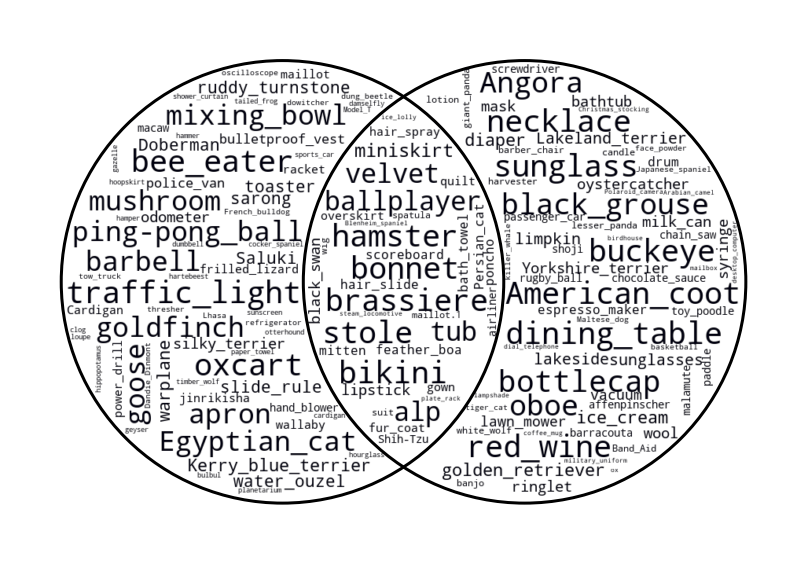

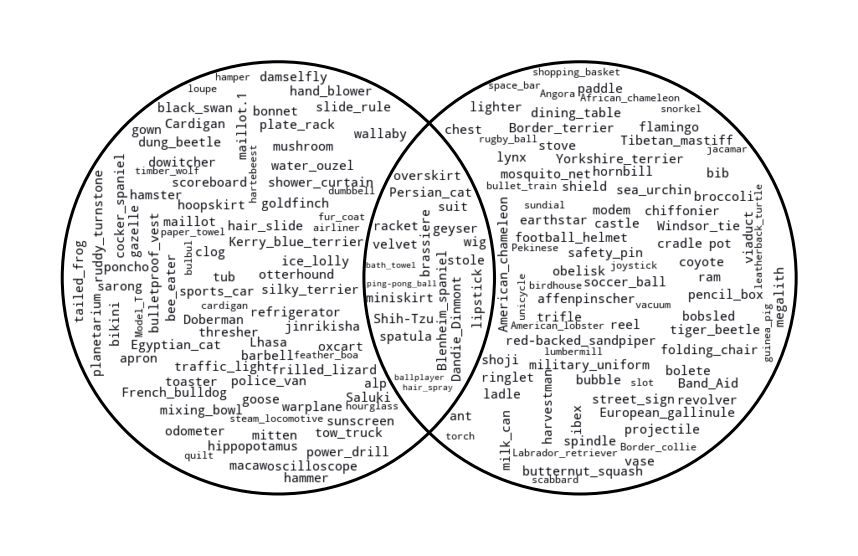

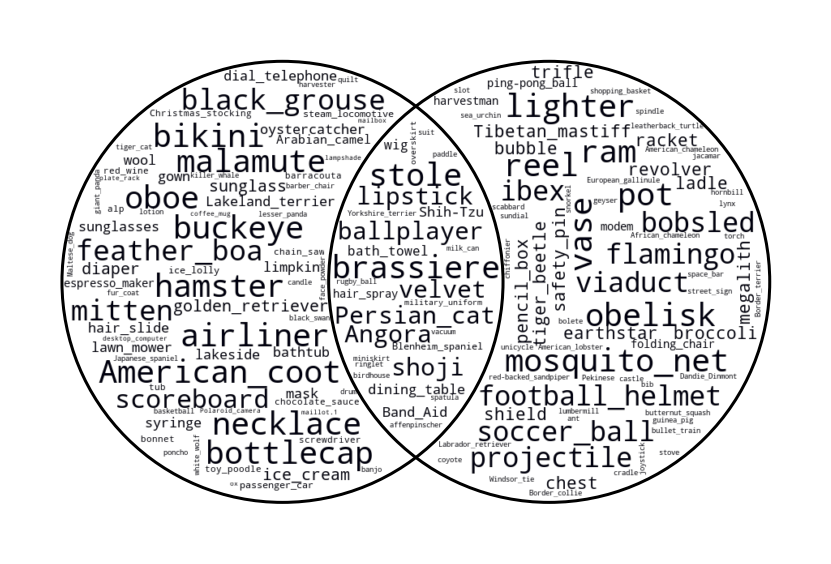

In [10]:
from matplotlib_venn_wordcloud import venn2_wordcloud
plt.rcParams['figure.figsize'] = [15, 10]
top_attr = 100
english = set([t[0] for t in info_gain[0][:top_attr]])
spanish = set([t[0] for t in info_gain[1][:top_attr]])
arab = set([t[0] for t in info_gain[2][:top_attr]])
venn2_wordcloud([english, spanish])
venn2_wordcloud([english, arab])
venn2_wordcloud([spanish, arab])
print(english.intersection(spanish).intersection(arab))

In [30]:
english = set([t[0] for t in info_gain[0] if t[1] > 0])
spanish = set([t[0] for t in info_gain[1] if t[1] > 0])
arab = set([t[0] for t in info_gain[2] if t[1] > 0])
for i in spanish.intersection(arab):
    print(i)

Sealyham_terrier
basset
consomme
cannon
goldfish
rock_crab
soccer_ball
snorkel
hen-of-the-woods
tennis_ball
acorn_squash
pencil_sharpener
vacuum
velvet
sea_urchin
pinwheel
Crock_Pot
West_Highland_white_terrier
mitten
handkerchief
wing
toaster
oxcart
canoe
chambered_nautilus
perfume
badger
red_wine
oxygen_mask
tusker
bald_eagle
tiger
Blenheim_spaniel
Windsor_tie
jersey
birdhouse
flute
American_egret
malamute
ptarmigan
partridge
mud_turtle
Shetland_sheepdog
banjo
stole
Band_Aid
mouse
vulture
wooden_spoon
baseball
fountain
guenon
chocolate_sauce
gazelle
kelpie
rugby_ball
tree_frog
forklift
lampshade
magpie
bottlecap
wallet
Japanese_spaniel
CD_player
panpipe
cabbage_butterfly
piggy_bank
bath_towel
Pembroke
dining_table
mountain_bike
bittern
tarantula
military_uniform
sea_cucumber
toy_poodle
lawn_mower
stretcher
schipperke
brass
terrapin
unicycle
hand_blower
wig
bee
coil
spatula
beer_bottle
scoreboard
marmot
mosquito_net
dragonfly
trolleybus
geyser
saltshaker
hamster
rubber_eraser
window_sh

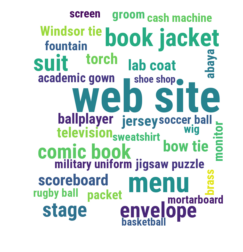

In [33]:
wordcloud = WordCloud(background_color='white', width=800, height=900, font_path="./assets/roboto-condensed.bold.ttf")
male = ["abaya", "academic gown", "ballplayer", "basketball", "book jacket", "bow tie", "brass", "cash machine", "comic book", "envelope", "fountain", "groom", "jersey", "jigsaw puzzle", "lab coat", "menu", "military uniform", "monitor", "mortarboard", "packet", "rugby ball", "scoreboard", "screen", "shoe shop", "soccer ball", "stage", "suit", "sweatshirt", "television", "torch", "web site", "wig", "Windsor tie"]
male_f = [0.03966420102, 0.03715537269, 0.05130371603, 0.02812480389, 0.1710920907, 0.06301534072, 0.03562286514, 0.03390118916, 0.1141696955, 0.1263663979, 0.03932854919, 0.0390230828, 0.05287246334, 0.039646971, 0.05727237877, 0.2303639421, 0.03577460919, 0.04080570376, 0.03087204625, 0.04142592542, 0.03076093856, 0.0628738015, 0.03279311667, 0.02568373911, 0.03540994222, 0.1114257513, 0.1464536098, 0.031961112, 0.05091713405, 0.05844243094, 0.8602515761, 0.03194434059, 0.04618145633]
# female_f = [0.0622797552, 0.03271088752, 0.03372412103, 0.1655590241, 0.04932278994, 0.04105550232, 0.03375362991, 0.03104595426, 0.03515851495, 0.09437384508, 0.1604337436, 0.03669965358, 0.04060210861, 0.03343573916, 0.04149327518, 0.04625420885, 0.04539604931, 0.04220070517, 0.04011028866, 0.2286903463, 0.04424281161, 0.03426832614, 0.02824550812, 0.05149768546, 0.03148627995, 0.02936321346, 0.1111438872, 0.03697557155, 0.08727041212, 0.03348071179, 0.03017160739, 0.04467874593, 0.02796469456, 0.03362179777, 0.8605201495, 0.0908990415]
# female = ["abaya", "academic gown", "Band Aid", "book jacket", "bow tie", "brass", "brassiere", "cash machine", "cloak", "comic book", "envelope", "fountain", "fur coat", "gown", "groom", "hair spray", "jersey", "jigsaw puzzle", "lab coat", "menu", "miniskirt", "monitor", "mortarboard", "packet", "pajama", "screen", "stage", "stole", "suit", "sunglasses", "sweatshirt", "television", "theater curtain", "torch", "web site", "wig"]
d = {}
for w, f in zip(male, male_f):
    d[w] = f
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud.to_file("male_freqs_wc.png")
# wc.to_file(path.join(d, imgname2))